# Predictive modeling

## 1. Objective
The aim of this problem is to predict rider retention. To help explore this question, I am working with a sample dataset of a cohort of users who signed up for an account in January 2014. The data was pulled several months later; A user is considered retained if they were “active” (i.e. took a trip) in the preceding 30 days.

I was asked to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help the operator. The data is in provided as a json file.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import shap

I loaded the database and converted it to a pandas dataframe.

In [2]:
with open('ultimate_data_challenge.json','r') as file:
    customers = json.load(file)
    
df = pd.DataFrame(customers)
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['city'] = df['city'].astype('category')
df['phone'] = df['phone'].astype('category')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## 2. Data Processing
The next few steps involve the cleaning, exploratory analysis, and/or visualizations on data for this analysis.

1. The first step was to look at the summary statitics; The range and distribution of the data is variable for the parameters in the dataset. I will use a min-max scaler to make sure the analysis is not be biased.

In [3]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


2. The next step was to identify the data types in the dataset. I am going to use the datetime parameters to develop a retention feature for the analysis. I will also encode the categorical variables as part of the model pipeline.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  category      
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  category      
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), category(2), datetime64[ns](2), fl

3. The last step for this part is to identify any missing data and decide how to deal with them.
    * The `avg_rating_of_driver` has lots of missing data. It is not surprising, because many riders would ignore the optional driver rating especially when they are relativelly satisfied with the service. Therefore, I expect most of the missing data refer to a situation when the rider feeling is about the average (i.e., not very happy and not very dissatisfied). As a result, I will impute the missing data with the mean driver ratings.
    * The phone type is missing for small portion of the customers. While it is not a large portion of the dataset, I prefer not to lose that part. So, I will identify the most popular phone type in the dataset and use that to impute the missing data.
    * Finally, A relatively small number of customers are missing the `avg_rating_by_driver`. It suggest that it is very likely that those customers did not take many trips. Because, I expect that at least one driver would provide a rating for the customer. Although, it is not a bad decision to remove those customers from the dataset, I am not going to drop those points as well. Given the small number of missing data point, I will use the average ratings to impute the missing data because it will have minimal impact on the results.

In [5]:
print(df.isnull().sum())

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64


In [6]:
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace = True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace = True)

popular_phone = list(dict(Counter(df['phone'])).keys())[0]
df['phone'].fillna(popular_phone, inplace = True)

print(df.isnull().sum())

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64


## 3. Feature Engineering
The goal of this part is to create a feature that can be used to identify the retained customers. According to the instructions a customer is assumed to be retained when they took a ride in the preceding 30 days.

   * The date and time that database was pulled is not known. So, I will assume the maximum of the maximum of the last trip date to be the time that database was pulled. It is a fair assumption because the database contains 50,000 customer records and it is very unlikely that no ride activity occurs for extended period of time.
   * The next task is to find the cut-off date and time for the retention. I will deduct 30 days from the database pull date and time and use that as the cut-off.
   * The last step is to parse the database and identify customers who took a ride between the cut-off date and the date database was pulled.
   * The label indicate about one third of clients were retained after 6 months on the system.

In [7]:
print('Let\'s assume the {} which is the max last_trip_date in the data is the day the data was pulled.'.format(df['last_trip_date'].max()))

Let's assume the 2014-07-01 00:00:00 which is the max last_trip_date in the data is the day the data was pulled.


In [8]:
begin_date = df['last_trip_date'].max() - pd.Timedelta(days=30)
end_date = df['last_trip_date'].max()

In [9]:
df['retained'] = (df['last_trip_date'] > begin_date) & (df['last_trip_date'] < end_date)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


## 4. EDA
Now that I have processed the database and created a label for retention, I am going to perform a quick exploratory analysis. I mainly want to know if there is any meaningful trend in the data.

   * There are some outliers in the number of trips in the first 30 days and average travel distance. Those outliers are actively using the service and are retained.
   * It is evident that the service is more popular in Winterfell; probably because of the extreme cold!!! (Just joking!)
   * The last plot shows the number of customers retained by phone type. I think iphone users are more interested in this service.

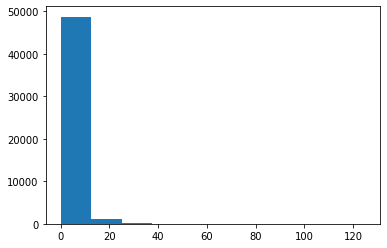

In [10]:
plt.hist(df['trips_in_first_30_days'])
plt.show();

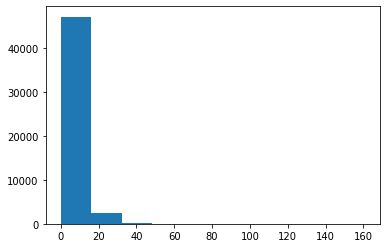

In [11]:
plt.hist(df['avg_dist'])
plt.show();

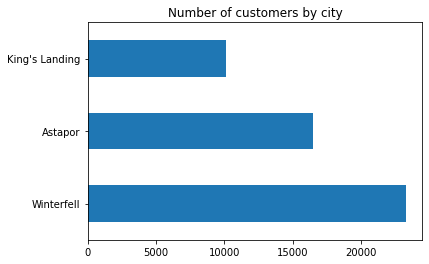

In [12]:
df['city'].value_counts().plot(kind = 'barh',title='Number of customers by city');

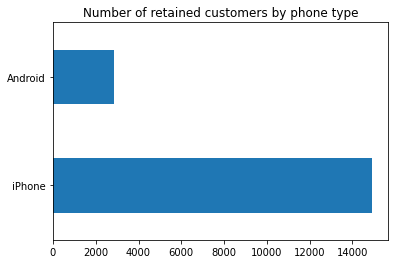

In [13]:
df[df['retained']]['phone'].value_counts().plot(kind = 'barh',title='Number of retained customers by phone type');

## 5. Classification
The present query is a classification problem and I am going to use three algorithms to tackle this problem:

   * Logistic regression: I used the logistic regression as a starting point and will use this as a baseline for the classification performance. Logistic regression is known for its speed and simple interpretation.
   * Random forest: It emphasizes feature selection, does not assume that the model has a linear relationship, and utilizes ensemble learning.
   * Gradient boosting: Finally, I will build a gradient boosting model to explore any performance gain if bias is an issue.


I will use the Scikit-Learn's BayesSearchCV to tune all three models. I will consider recall of the not-retained customers class (i.e., `retained == False`) as a key metric for this problem. Because, the service proider may be able to retain some of those clients if it can identify them and offer them some incentives.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from skopt import BayesSearchCV
from sklearn.metrics import classification_report

### 5.1. Model pipeline
I created a pipeline consisting a transformer to make necessary data transformation on categorical and numerical features, followed by the classification model. I defined a paramater grid for hyper-parameter optimization of each classification model.

The data will be divided to %75 train and %25 test.

In [15]:
X = df.drop(columns=['retained', 'last_trip_date', 'signup_date'])
y = df['retained']

# determine categorical and numerical features
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object', 'bool', 'category']).columns

columnTransformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_columns),
    ('num', MinMaxScaler(), numerical_columns)],
    remainder='passthrough')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

#### 5.1.1. Logistic Regression

In [17]:
lr_model = LogisticRegression()
lr_pipeline = Pipeline([('transformer',columnTransformer),
                ('classifier', lr_model)])
lr_params = {'classifier__C': (1e-5, 1e2, "log-uniform"),}
lr_search = BayesSearchCV(estimator=lr_pipeline, search_spaces=lr_params, n_iter=32)
lr_search.fit(X_train, y_train)

BayesSearchCV(estimator=Pipeline(steps=[('transformer',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('encoder',
                                                                          OneHotEncoder(),
                                                                          Index(['city', 'phone', 'ultimate_black_user'], dtype='object')),
                                                                         ('num',
                                                                          MinMaxScaler(),
                                                                          Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'],
      dtype='object'))])),
                                        ('classifier', LogisticRegression())]),
              n_iter=32,
              search_spac

In [18]:
print('The average score for the logistic regression classifier on the training data is {}'.format(lr_search.best_score_))

y_pred_lr = lr_search.predict(X_test)

print(classification_report(y_test, y_pred_lr))

The average score for the logistic regression classifier on the training data is 0.7194933333333334
              precision    recall  f1-score   support

       False       0.75      0.87      0.81      8088
        True       0.67      0.47      0.55      4412

    accuracy                           0.73     12500
   macro avg       0.71      0.67      0.68     12500
weighted avg       0.72      0.73      0.72     12500



#### 5.1.2. Random Forest


In [19]:
rf_model = RandomForestClassifier(random_state=22)
rf_pipeline = Pipeline([('transformer',columnTransformer),
                ('classifier', rf_model)])

rf_params = {'classifier__n_estimators': [200, 500],
             'classifier__max_features': ['auto', 'sqrt', 'log2'],
             'classifier__max_depth' : list(range(2,7)),}
rf_search = BayesSearchCV(estimator=rf_pipeline, search_spaces=rf_params, n_iter=32)
rf_search.fit(X_train, y_train)

BayesSearchCV(estimator=Pipeline(steps=[('transformer',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('encoder',
                                                                          OneHotEncoder(),
                                                                          Index(['city', 'phone', 'ultimate_black_user'], dtype='object')),
                                                                         ('num',
                                                                          MinMaxScaler(),
                                                                          Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'],
      dtype='object'))])),
                                        ('classifier',
                                         RandomForestClassifier(random_stat

In [20]:
print('The average score for the random forest classifier on the training data is {}'.format(rf_search.best_score_))

y_pred_rf = rf_search.predict(X_test)

print(classification_report(y_test, y_pred_rf))

The average score for the random forest classifier on the training data is 0.7711733333333333
              precision    recall  f1-score   support

       False       0.79      0.90      0.84      8088
        True       0.75      0.56      0.64      4412

    accuracy                           0.78     12500
   macro avg       0.77      0.73      0.74     12500
weighted avg       0.77      0.78      0.77     12500



#### 5.1.3. Gradient Boosting


In [21]:
gb_model = GradientBoostingClassifier(random_state=22)
gb_pipeline = Pipeline([('transformer',columnTransformer),
                ('classifier', gb_model)])
gb_params = {'classifier__n_estimators': list(range(100,700)),
             'classifier__learning_rate': (1e-4, 1.0, "log-uniform"),
             'classifier__max_depth' : list(range(1,5)),}
gb_search = BayesSearchCV(estimator=gb_pipeline, search_spaces=gb_params, n_iter=32)
gb_search.fit(X_train, y_train)

BayesSearchCV(estimator=Pipeline(steps=[('transformer',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('encoder',
                                                                          OneHotEncoder(),
                                                                          Index(['city', 'phone', 'ultimate_black_user'], dtype='object')),
                                                                         ('num',
                                                                          MinMaxScaler(),
                                                                          Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'],
      dtype='object'))])),
                                        ('classifier',
                                         GradientBoostingClassifier(random_

In [22]:
print('The average score for the random forest classifier on the training data is {}'.format(gb_search.best_score_))

y_pred_gb = gb_search.predict(X_test)

print(classification_report(y_test, y_pred_gb))

The average score for the random forest classifier on the training data is 0.7860266666666667
              precision    recall  f1-score   support

       False       0.82      0.87      0.84      8088
        True       0.73      0.65      0.69      4412

    accuracy                           0.79     12500
   macro avg       0.77      0.76      0.76     12500
weighted avg       0.79      0.79      0.79     12500



In [23]:
gb_search.best_params_

OrderedDict([('classifier__learning_rate', 0.16806128929109168),
             ('classifier__max_depth', 4),
             ('classifier__n_estimators', 100)])

The results indicate that both ensemble techniques (i.e., Random Forest and Gradient Boosting) reach about %78 overall accuracy and are able to identify about %90 of clients who are not retained (see the recall of the `False` class). The service provider may reach to those clients and offer them coupons to encourage them remain on the platform.

## Explain the Model 
I use SHAP to evaluate the impact of each feature on model's predictions. For this purpose, I re-construct the gboost model using the `best_params` identified by the BayesSearch.

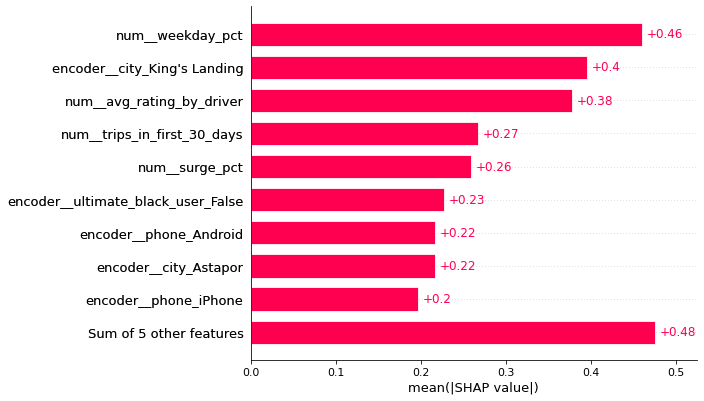

In [24]:
learning_rate = gb_search.best_params_['classifier__learning_rate']
max_depth = gb_search.best_params_['classifier__max_depth']
n_estimators = gb_search.best_params_['classifier__n_estimators']

X_transformed = columnTransformer.fit_transform(X_train)
X_transformed = pd.DataFrame(X_transformed, columns = columnTransformer.get_feature_names_out())

model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate = learning_rate, random_state=22).fit(X_transformed,y_train)
explainer = shap.Explainer(model)
shap_values = explainer(X_transformed)
shap.plots.bar(shap_values)

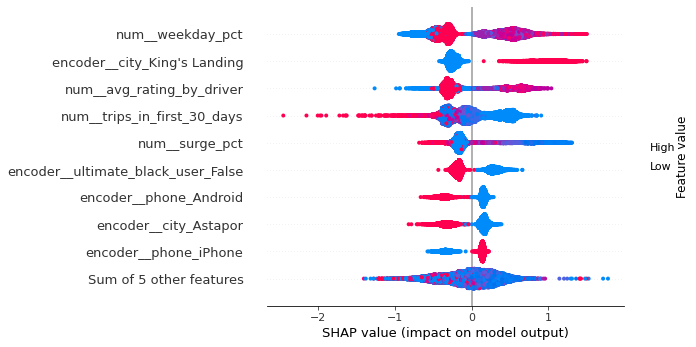

In [25]:
shap.plots.beeswarm(shap_values)

Results indicate that the number of trips on a weekday, and number of trips on the first 30 days are strong factors for customers retention.